# Stance Classification In Tweets

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import keras 
import re
import pathlib
import tempfile
import shutil
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Convolution2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
from  IPython import display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from statsmodels.graphics.mosaicplot import mosaic
tf.keras.optimizers.RMSprop
get_ipython().run_line_magic('matplotlib', 'inline')
import os
tf.__version__

Using TensorFlow backend.


'2.0.2'

## Upload and unzip data file

In [2]:
import zipfile
with zipfile.ZipFile('./StanceDataset.zip', 'r') as zip_ref:
 zip_ref.extractall('./')

## Reading training data

In [3]:
train = pd.read_csv('./StanceDataset/train.csv', index_col=None, header=0, engine='python' )

## Understand Data and Preprocessing

In [4]:
train.shape

(2914, 5)

## Checking shape of training data and creating a plot to analyse Bias in data

In [5]:
#grouping
shape_data_group_target= train.groupby(["Target"])
shape_data_group_plot_target= shape_data_group_target.count()

,Tweet,Stance,Opinion Towards,Sentiment
Target,,,,
Atheism,513,513,513,513
Climate Change is a Real Concern,395,395,395,395
Feminist Movement,664,664,664,664
Hillary Clinton,689,689,689,689
Legalization of Abortion,653,653,653,653


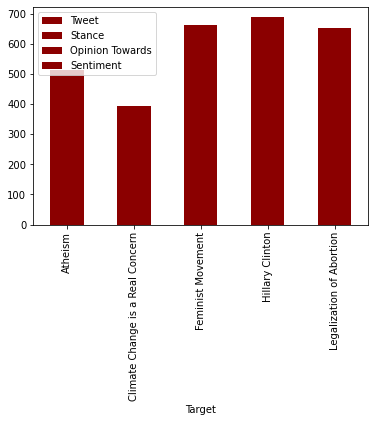

In [6]:
#plotting bar chart
shape_data_group_plot_target.plot(kind='bar',color=('darkred'))
shape_data_group_target.count()

,Tweet,Target,Opinion Towards,Sentiment
Stance,,,,
AGAINST,1395,1395,1395,1395
FAVOR,753,753,753,753
NONE,766,766,766,766


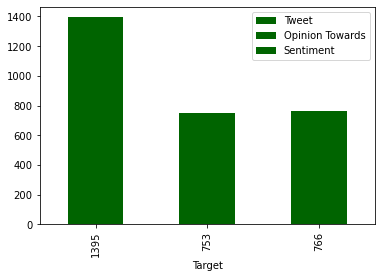

In [7]:
#grouping
shape_data_group_stance= train.groupby(["Stance"])
shape_data_group_plot_stance= shape_data_group_stance.count()
#plotting bar chart
shape_data_group_plot_stance.plot('Target',kind='bar',color=('darkgreen'))
shape_data_group_stance.count()

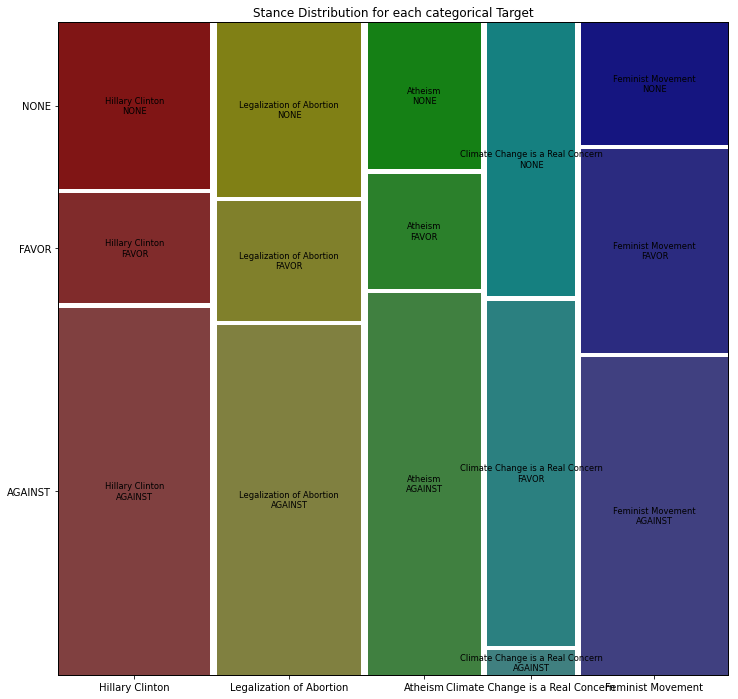

In [8]:
df1 = pd.DataFrame(train,columns=['Target','Stance'])

from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 10.0
plt.rcParams["figure.figsize"]=(12.0, 12.0)
mosaic(df1, ['Target', 'Stance'],gap=0.01,title='Stance Distribution for each categorical Target');


## Splitting Data into TRAIN, TEST AND VALIDATION

In [9]:

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(train,test_size = 0.2)
training_data, validation_data = train_test_split(train_data,test_size = 0.2)

# Generate two data frames for training and validation #
print('Train size: {}, Test size: {}'.format(training_data.shape[0], validation_data.shape[0] ) ) 
N_train = training_data.shape[0]
N_val = validation_data.shape[0]

Train size: 1864, Test size: 467


In [10]:
training_data.shape

(1864, 5)

In [11]:
test_data.shape

(583, 5)

In [12]:
validation_data.shape

(467, 5)

In [13]:
training_data

,Tweet,Target,Stance,Opinion Towards,Sentiment
1727,"@Bluesaloon Women are not a demographic, we ar...",Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,neg
2601,Every good Christian wants to make sure the un...,Legalization of Abortion,NONE,2. The tweet does NOT expresses opinion about ...,neg
1996,Fox News predicting 3 way marriage-gee we have...,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,neg
321,"The world was made a better place today, even ...",Atheism,NONE,2. The tweet does NOT expresses opinion about ...,pos
1371,Men want women to take their name in marriage ...,Feminist Movement,FAVOR,1. The tweet explicitly expresses opinion abo...,neg
...,...,...,...,...,...
1304,#feminists gave women the right to vote. #femi...,Feminist Movement,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
112,"RT @prayerbullets: Let the righteousness, peac...",Atheism,AGAINST,2. The tweet does NOT expresses opinion about ...,pos
364,Humanist Canada stands by the US Supreme Court...,Atheism,NONE,2. The tweet does NOT expresses opinion about ...,pos
807,Dallas still hasn't hit 100 this year. #SemST,Climate Change is a Real Concern,NONE,3. The tweet is not explicitly expressing opi...,other


## Cleaning Data

In [14]:
training_data = training_data.applymap(str)

In [15]:
training_data["Tweet"] = training_data["Tweet"].apply(str)

In [16]:
training_data.info

<bound method DataFrame.info of                                                   Tweet  \
1727  @Bluesaloon Women are not a demographic, we ar...   
2601  Every good Christian wants to make sure the un...   
1996  Fox News predicting 3 way marriage-gee we have...   
321   The world was made a better place today, even ...   
1371  Men want women to take their name in marriage ...   
...                                                 ...   
1304  #feminists gave women the right to vote. #femi...   
112   RT @prayerbullets: Let the righteousness, peac...   
364   Humanist Canada stands by the US Supreme Court...   
807       Dallas still hasn't hit 100 this year. #SemST   
1726  Chipotle employees shouldn't complain Hillary ...   

                                Target   Stance  \
1727                   Hillary Clinton     NONE   
2601          Legalization of Abortion     NONE   
1996                   Hillary Clinton     NONE   
321                            Atheism     NONE   
1371

In [17]:

# Apply a first round of text cleaning techniques
import re
import string

def clean_text_round1(text):
    ''' Remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
round1 = lambda x: clean_text_round1(x)


In [18]:

# Let's take a look at the updated text
training_data['Tweet'] = training_data['Tweet'].apply(round1)
training_data.head(5)

,Tweet,Target,Stance,Opinion Towards,Sentiment
1727,Bluesaloon Women are not a demographic we are ...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,neg
2601,Every good Christian wants to make sure the un...,Legalization of Abortion,NONE,2. The tweet does NOT expresses opinion about ...,neg
1996,Fox News predicting way marriagegee we have t...,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,neg
321,The world was made a better place today even i...,Atheism,NONE,2. The tweet does NOT expresses opinion about ...,pos
1371,Men want women to take their name in marriage ...,Feminist Movement,FAVOR,1. The tweet explicitly expresses opinion abo...,neg


In [19]:
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text
round2 = lambda x: clean_text_round2(x)


In [20]:
# Let's take a look at the updated text
training_data['Tweet'] = training_data['Tweet'].apply(round2)
training_data.head(5)

,Tweet,Target,Stance,Opinion Towards,Sentiment
1727,Bluesaloon Women are not a demographic we are ...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,neg
2601,Every good Christian wants to make sure the un...,Legalization of Abortion,NONE,2. The tweet does NOT expresses opinion about ...,neg
1996,Fox News predicting way marriagegee we have t...,Hillary Clinton,NONE,2. The tweet does NOT expresses opinion about ...,neg
321,The world was made a better place today even i...,Atheism,NONE,2. The tweet does NOT expresses opinion about ...,pos
1371,Men want women to take their name in marriage ...,Feminist Movement,FAVOR,1. The tweet explicitly expresses opinion abo...,neg


## Data Engineering

Categorical to numerical

In [21]:
encode = {
    "Hillary Clinton" : 0,
    "Legalization of Abortion"  : 1,       
    "Atheism" : 2,    
    "Climate Change is a Real Concern" : 3,     
    "Feminist Movement"  : 4    
        
    
}

training_data["Target"] = training_data["Target"].apply(lambda x: encode[x])
training_data.head(5)

,Tweet,Target,Stance,Opinion Towards,Sentiment
1727,Bluesaloon Women are not a demographic we are ...,0,NONE,3. The tweet is not explicitly expressing opi...,neg
2601,Every good Christian wants to make sure the un...,1,NONE,2. The tweet does NOT expresses opinion about ...,neg
1996,Fox News predicting way marriagegee we have t...,0,NONE,2. The tweet does NOT expresses opinion about ...,neg
321,The world was made a better place today even i...,2,NONE,2. The tweet does NOT expresses opinion about ...,pos
1371,Men want women to take their name in marriage ...,4,FAVOR,1. The tweet explicitly expresses opinion abo...,neg


In [22]:
training_data["Sentiment"].unique()

array(['neg', 'pos', 'other'], dtype=object)

In [23]:
training_data["Stance"].unique()

array(['NONE', 'FAVOR', 'AGAINST'], dtype=object)

In [24]:
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

happy_lines = list()
lines = training_data["Tweet"].values.tolist()
def remove_punct(lines):
    lines  = "".join([char for char in lines if char not in string.punctuation])
    lines = re.sub('[0-9]+', '', lines)
    return lines

training_data['Tweet'] = training_data['Tweet'].apply(lambda x: remove_punct(x))
training_data.head(5)

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Tweet,Target,Stance,Opinion Towards,Sentiment
1727,Bluesaloon Women are not a demographic we are ...,0,NONE,3. The tweet is not explicitly expressing opi...,neg
2601,Every good Christian wants to make sure the un...,1,NONE,2. The tweet does NOT expresses opinion about ...,neg
1996,Fox News predicting way marriagegee we have t...,0,NONE,2. The tweet does NOT expresses opinion about ...,neg
321,The world was made a better place today even i...,2,NONE,2. The tweet does NOT expresses opinion about ...,pos
1371,Men want women to take their name in marriage ...,4,FAVOR,1. The tweet explicitly expresses opinion abo...,neg


In [25]:
def tokenization(lines):
    lines = re.split('\W+', lines)
    return lines

training_data['Tweet'] = training_data['Tweet'].apply(lambda x: tokenization(x.lower()))
training_data.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
1727,"[bluesaloon, women, are, not, a, demographic, ...",0,NONE,3. The tweet is not explicitly expressing opi...,neg
2601,"[every, good, christian, wants, to, make, sure...",1,NONE,2. The tweet does NOT expresses opinion about ...,neg
1996,"[fox, news, predicting, way, marriagegee, we, ...",0,NONE,2. The tweet does NOT expresses opinion about ...,neg
321,"[the, world, was, made, a, better, place, toda...",2,NONE,2. The tweet does NOT expresses opinion about ...,pos
1371,"[men, want, women, to, take, their, name, in, ...",4,FAVOR,1. The tweet explicitly expresses opinion abo...,neg


In [26]:
import nltk 
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
stopword = nltk.corpus.stopwords.words('english')

In [29]:
def remove_stopwords(lines):
    lines = [word for word in lines if word not in stopword]
    return lines
    
training_data['Tweet'] = training_data['Tweet'].apply(lambda x: remove_stopwords(x))
training_data.head(5)

,Tweet,Target,Stance,Opinion Towards,Sentiment
1727,"[bluesaloon, women, demographic, least, nation...",0,NONE,3. The tweet is not explicitly expressing opi...,neg
2601,"[every, good, christian, wants, make, sure, un...",1,NONE,2. The tweet does NOT expresses opinion about ...,neg
1996,"[fox, news, predicting, way, marriagegee, morm...",0,NONE,2. The tweet does NOT expresses opinion about ...,neg
321,"[world, made, better, place, today, even, smal...",2,NONE,2. The tweet does NOT expresses opinion about ...,pos
1371,"[men, want, women, take, name, marriage, male,...",4,FAVOR,1. The tweet explicitly expresses opinion abo...,neg


In [30]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [31]:
wn = nltk.WordNetLemmatizer()

def lemmatizer(lines):
    lines = [wn.lemmatize(word) for word in lines]
    return lines

training_data['Tweet'] = training_data['Tweet'].apply(lambda x: lemmatizer(x))
training_data.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
1727,"[bluesaloon, woman, demographic, least, nation...",0,NONE,3. The tweet is not explicitly expressing opi...,neg
2601,"[every, good, christian, want, make, sure, unw...",1,NONE,2. The tweet does NOT expresses opinion about ...,neg
1996,"[fox, news, predicting, way, marriagegee, morm...",0,NONE,2. The tweet does NOT expresses opinion about ...,neg
321,"[world, made, better, place, today, even, smal...",2,NONE,2. The tweet does NOT expresses opinion about ...,pos
1371,"[men, want, woman, take, name, marriage, male,...",4,FAVOR,1. The tweet explicitly expresses opinion abo...,neg


In [32]:
lines = training_data["Tweet"].values.tolist()

In [33]:
happy_lines = lines

In [34]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

validation_split = 0.20
max_length = 55

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(happy_lines)
sequences = tokenizer_obj.texts_to_sequences(happy_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab_size - '+str(vocab_size))

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
category =  training_data['Target'].values

unique tokens - 6073
vocab_size - 6074


In [35]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/models

In [36]:
from itertools import cycle
def plotter(history_hold, metric = 'binary_crossentropy', ylim=[0.0, 1.0]):
  cycol = cycle('bgrcmk')
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0,len(y_val))

    c=next(cycol)

    plt.plot(x_train, y_train, c+'-', label=name+'_train')
    plt.plot(x_train, y_val, c+'--', label=name+'_val')

  plt.legend()
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)

In [37]:
indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
category = category[indices]

n_values = np.max(category) + 1
Y = np.eye(n_values)[category]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = Y[:-num_validation_samples]
X_val_pad = lines_pad[-num_validation_samples:]
y_val = Y[-num_validation_samples:]

In [38]:
# Randomly sample some train data
train_len = X_train_pad.shape[0]

idx = np.random.randint(train_len, size=train_len//25)

X_train_pad_sampled = X_train_pad[idx, :]
y_train_sampled = y_train[idx]

In [39]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_train_pad_sampled:', X_train_pad_sampled.shape)
print('Shape of y_train_sampled:', y_train_sampled.shape)

print('Shape of X_test_pad:', X_val_pad.shape)
print('Shape of y_test:', y_val.shape)

Shape of X_train_pad: (1492, 55)
Shape of y_train: (1492, 5)
Shape of X_train_pad_sampled: (59, 55)
Shape of y_train_sampled: (59, 5)
Shape of X_test_pad: (372, 55)
Shape of y_test: (372, 5)


In [40]:
def get_callbacks(name):
  return [
    tf.keras.callbacks.TensorBoard(logdir/name, histogram_freq=1),
  ]

In [41]:

from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from tensorflow.keras.models import Sequential

embedding_dim = 100

embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            input_length=max_length,
                            trainable=True)

model_glove = Sequential()
model_glove.add(embedding_layer)
model_glove.add(LSTM(units=32,  dropout=0.2, recurrent_dropout=0.25))
model_glove.add(Dense(5, activation='softmax'))

model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

print(model_glove.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 55, 100)           607400    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 624,589
Trainable params: 624,589
Non-trainable params: 0
_________________________________________________________________
None


In [42]:
EPOCH = 5

In [43]:

m_histories = {}
m_histories['no_TL'] = model_glove.fit(X_train_pad_sampled, y_train_sampled, batch_size=32, epochs=EPOCH, validation_data=(X_val_pad, y_val), callbacks=get_callbacks('models/no_TL'), verbose=1)

Train on 59 samples, validate on 372 samples
Epoch 1/5
59/59 [==============================] - 3s 58ms/sample - loss: 1.6165 - categorical_accuracy: 0.1356 - val_loss: 1.6175 - val_categorical_accuracy: 0.1210
Epoch 2/5
59/59 [==============================] - 0s 5ms/sample - loss: 1.6036 - categorical_accuracy: 0.2203 - val_loss: 1.6175 - val_categorical_accuracy: 0.2097
Epoch 3/5
59/59 [==============================] - 0s 4ms/sample - loss: 1.5865 - categorical_accuracy: 0.3390 - val_loss: 1.6202 - val_categorical_accuracy: 0.2097
Epoch 4/5
59/59 [==============================] - 0s 4ms/sample - loss: 1.5763 - categorical_accuracy: 0.3390 - val_loss: 1.6236 - val_categorical_accuracy: 0.2097
Epoch 5/5
59/59 [==============================] - 0s 4ms/sample - loss: 1.5754 - categorical_accuracy: 0.3390 - val_loss: 1.6284 - val_categorical_accuracy: 0.2097


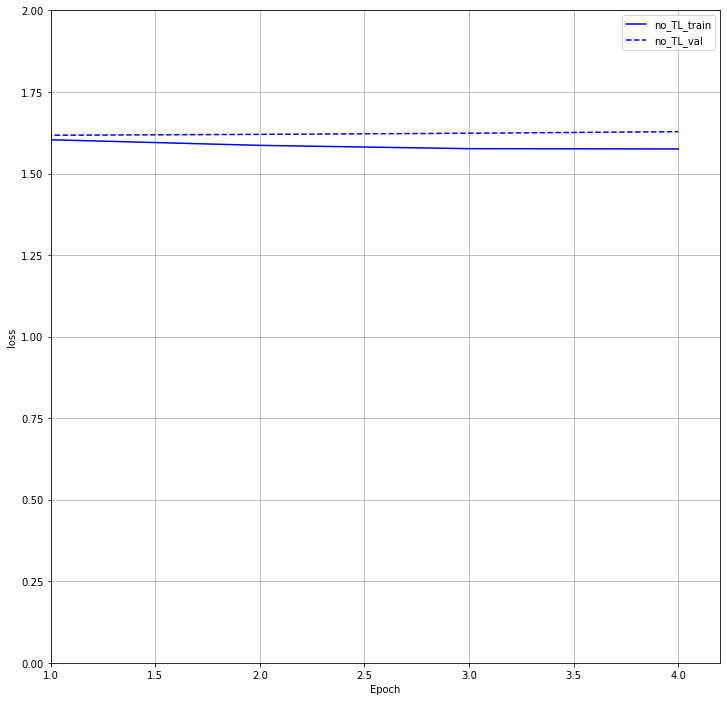

In [44]:
plotter(m_histories, ylim=[0.0, 2.0], metric = 'loss')

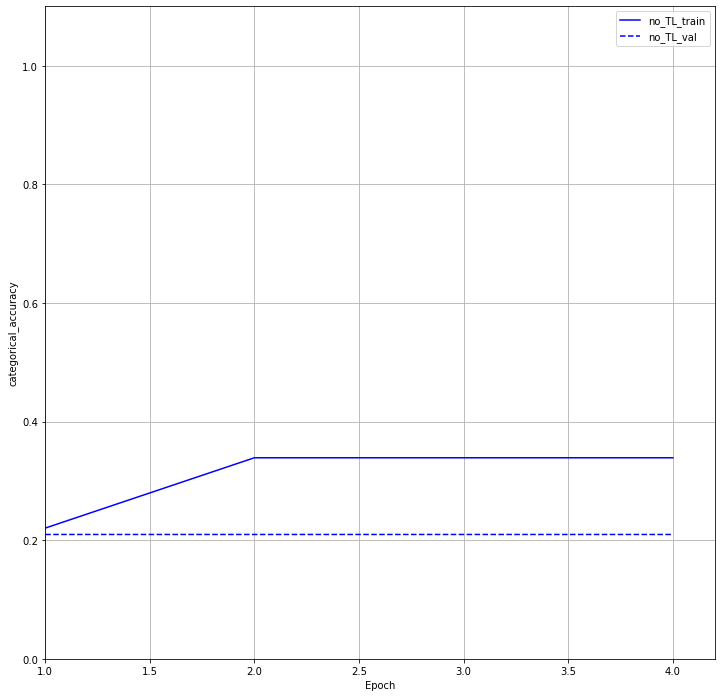

In [45]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'categorical_accuracy')

In [46]:
file = open('glove.twitter.27B.100d.txt', encoding='utf-8')

glove_vectors = dict()
for line in file:
  values = line.split()
  word = values[0]
  features = np.asarray(values[1:])
  glove_vectors[word] = features

file.close() 

FileNotFoundError: [Errno 2] No such file or directory: 'glove.twitter.27B.100d.txt'

In [ ]:

E_T = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
        E_T[i] = embedding_vector

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from tensorflow.keras.models import Sequential

embedding_layer_TL = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[E_T],
                            input_length=max_length,
                            trainable=False)

model_glove = Sequential()
model_glove.add(embedding_layer_TL)
model_glove.add(LSTM(units=64,  dropout=0.5, recurrent_dropout=0.5))
model_glove.add(Dense(5, activation='softmax'))

model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

print(model_glove.summary())

In [ ]:
EPOCH = 100

In [ ]:
m_histories['with_TL'] = model_glove.fit(X_train_pad, y_train, batch_size=32, epochs=EPOCH, validation_data=(X_val_pad, y_val), callbacks=get_callbacks('models/with_TL'), verbose=1)

In [ ]:
plotter(m_histories, ylim=[0.0, 2], metric = 'loss')

In [ ]:
plotter(m_histories, ylim=[0.0, 1.1], metric = 'categorical_accuracy')